In this part we use learned KNN setting to test on external dataset: UPITT.  
What will be transferred here is: train dataset of KUMC as patient pool, best distance measure for each k, best weight combination for each k.  
The external validation set will be of the same size as train/test set with 50% AKI patients and 50% non-AKI patients. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
from tqdm.auto import tqdm
import json
from sklearn.metrics import pairwise_distances
from Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort, slow_argsort, min_max_normalization
%store -r raw_path

from v2_B_Pairwise_Data_Overlap import check_matrix_sanity

%store -r normal_distribution_SCR
%store -r norm_feature_importance
%store -r lab_feature_space
%store -r time_window

ModuleNotFoundError: No module named 'icdmappings'

# Preprocess UPITT Data

In [2]:
# define data storage path
data_path = raw_path + "UPITT" + '/raw/'

In [3]:
#Read in Onsets data and only use KUMC data
All_onsets = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/NEW_ONSETS.csv')
ONSET = All_onsets.loc[All_onsets.CENTER_NAME == "UPITT"].copy(deep = True)

/scratch/local/34088068/ipykernel_4144892/2375893198.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  All_onsets = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/NEW_ONSETS.csv')


In [4]:
#read in lab
LAB = pd.read_csv(data_path + 'AKI_LAB.csv', delimiter = ',', 
                  usecols=['PATID', 'LAB_LOINC', 'SPECIMEN_DATE', 'RESULT_NUM'])

In [5]:
# Read in SCr trajectories
SCR_use_cols = ['ONSETS_ENCOUNTERID','PATID','ENCOUNTERID','SPECIMEN_DATE','RESULT_NUM', 'DAYS_SINCE_ADMIT']
SCR = pd.read_csv(data_path + "AKI_LAB_SCR.csv", delimiter = ',', usecols=SCR_use_cols)

In [6]:
#format datatype for merge
#exclude those baseline SCr > 3.5, which indicate poor renal functions
ONSET = ONSET.loc[ONSET.SERUM_CREAT_BASE < 3.5, :]

ONSET[["PATID", "ONSETS_ENCOUNTERID"]] = ONSET[["PATID", "ONSETS_ENCOUNTERID"]].astype(str)

time_cols = ["ADMIT_DATE", "DISCHARGE_DATE", "AKI1_ONSET", "AKI2_ONSET", "AKI3_ONSET"]
for time_col in time_cols:
    ONSET[time_col] = pd.to_datetime(ONSET[time_col], format = "mixed")
    
# binary predictiton task
ONSET["EARLIEST_ONSET_DATE"] = np.min(ONSET[["AKI1_ONSET", "AKI2_ONSET", "AKI3_ONSET"]],
                                      axis = 1)
ONSET["AKI_LABEL"] = ONSET["EARLIEST_ONSET_DATE"].notna().astype(int)

ONSET.drop(["CENTER_NAME", "SERUM_CREAT_BASE", "NONAKI_SINCE_ADMIT", "AKI1_ONSET",
           "AKI2_ONSET", "AKI3_ONSET"], axis = 1, inplace = True)

In [7]:
#process data type 
SCR["PATID"] = SCR["PATID"].astype(str)

In [8]:
ONSET_SCR = ONSET.merge(SCR[["PATID", "SPECIMEN_DATE", "RESULT_NUM"]], on = "PATID",
                       how = "left")

In [9]:
#after merging, process date time
ONSET_SCR["SPECIMEN_DATE"] = pd.to_datetime(ONSET_SCR["SPECIMEN_DATE"], format = "mixed")

In [10]:
#filter out those beyond this hospitalization (we also need history prior to this hospitalization)
ONSET_SCR = ONSET_SCR.loc[ONSET_SCR.SPECIMEN_DATE <= ONSET_SCR.DISCHARGE_DATE, :]
ONSET_SCR = ONSET_SCR.sort_values(by=['PATID', 'ADMIT_DATE', 'SPECIMEN_DATE'])

# get average SCr on the same day
ONSET_SCR_avg = ONSET_SCR.groupby(['PATID', 'ONSETS_ENCOUNTERID', 'SPECIMEN_DATE'])['RESULT_NUM'].mean().reset_index()

In [11]:
# append the info back
ONSET_SCR_app = ONSET_SCR.loc[:, ["PATID", "ONSETS_ENCOUNTERID", "ADMIT_DATE",
                                  "DISCHARGE_DATE", "EARLIEST_ONSET_DATE", "AKI_LABEL"]]
ONSET_SCR_app.drop_duplicates(inplace = True)
ONSET_SCR_avg = ONSET_SCR_app.merge(ONSET_SCR_avg, on = ["PATID", "ONSETS_ENCOUNTERID"],
                                   how = "left")

In [12]:
# get the prediction point for non-AKI patient
non_AKI_pat = ONSET_SCR_avg.loc[ONSET_SCR_avg.AKI_LABEL == 0, 
                                ["PATID", "ONSETS_ENCOUNTERID", "SPECIMEN_DATE"]]

In [13]:
non_AKI_pat.drop_duplicates(subset = ["PATID", "ONSETS_ENCOUNTERID"], keep = "last",
                           inplace = True)

In [14]:
non_AKI_pat.rename(columns = {"SPECIMEN_DATE": "PREDICTION_POINT"}, inplace = True)

In [15]:
ONSET_SCR_avg = ONSET_SCR_avg.merge(non_AKI_pat, on = ["PATID", "ONSETS_ENCOUNTERID"],
                                   how = "left")

In [16]:
ONSET_SCR_avg.loc[ONSET_SCR_avg.AKI_LABEL == 1, "PREDICTION_POINT"] = \
ONSET_SCR_avg.loc[ONSET_SCR_avg.AKI_LABEL == 1, "EARLIEST_ONSET_DATE"]

In [17]:
#check that we have predicition point for each encounter
assert(ONSET_SCR_avg.PREDICTION_POINT.isna().mean() == 0)

In [18]:
# the time frame we need for SCr is the -7 to -1 days prior to prediction point
ONSET_SCR_avg = ONSET_SCR_avg[(ONSET_SCR_avg.SPECIMEN_DATE < ONSET_SCR_avg.PREDICTION_POINT) & \
                             (ONSET_SCR_avg.SPECIMEN_DATE >= ONSET_SCR_avg.PREDICTION_POINT - \
                             pd.Timedelta(days=7))]

In [19]:
#drop patients with less than 2 SCr measurements during the 7-day window
# group them and calcualte number of measurements
measure_num = ONSET_SCR_avg.groupby('ONSETS_ENCOUNTERID').size()
encounterID_to_drop = measure_num[measure_num < 2].index
ONSET_SCR_avg = ONSET_SCR_avg.loc[~ONSET_SCR_avg.ONSETS_ENCOUNTERID.isin(encounterID_to_drop), :]

In [20]:
#pivot all the SCr values, that is create features -7 ~ -1 and entries are RESULT_NUM
ONSET_SCR_avg["DAYS_BEFORE_PREDICTION_POINT"] = (ONSET_SCR_avg["SPECIMEN_DATE"] - \
ONSET_SCR_avg["PREDICTION_POINT"]).dt.days

#prepare a skleleton to merge on
unique_encounterids = list(ONSET_SCR_avg['ONSETS_ENCOUNTERID'].unique())
time_window = np.arange(-7, 0)  # from -7 to -1
skeleton = pd.MultiIndex.from_product([unique_encounterids, time_window], 
                                              names=['ONSETS_ENCOUNTERID', 
                                                     'DAYS_BEFORE_PREDICTION_POINT']).to_frame(index=False)
#merge on
skeleton = pd.merge(skeleton, ONSET_SCR_avg, 
                     on=['ONSETS_ENCOUNTERID', 'DAYS_BEFORE_PREDICTION_POINT'],
                     how='left')

#pivot
ONSET_SCR_formatted = skeleton.pivot(index='ONSETS_ENCOUNTERID', 
                                          columns='DAYS_BEFORE_PREDICTION_POINT', 
                                          values='RESULT_NUM').reset_index()

# get other info back
ONSET_SCR_app2 = ONSET_SCR_avg.loc[:, ["PATID", "ONSETS_ENCOUNTERID", "ADMIT_DATE", "DISCHARGE_DATE", 
                                       "PREDICTION_POINT", "AKI_LABEL"]]
ONSET_SCR_app2.drop_duplicates(inplace = True)
ONSET_SCR_formatted = ONSET_SCR_formatted.merge(ONSET_SCR_app2, on = "ONSETS_ENCOUNTERID", how = "left")

In [21]:
# only keep the earliest encounter of each patient
ONSET_SCR_formatted = ONSET_SCR_formatted.sort_values(by=['PATID', 'ADMIT_DATE'])
ONSET_SCR_formatted = ONSET_SCR_formatted.drop_duplicates(subset='PATID', keep='first')

In [22]:
LAB["PATID"] = LAB["PATID"].astype(str)

In [23]:
# merge the lab 
ONSET_SCR_LAB = ONSET_SCR_formatted.merge(LAB, on = "PATID", how = "left")

In [24]:
ONSET_SCR_LAB["SPECIMEN_DATE"] = \
pd.to_datetime(ONSET_SCR_LAB["SPECIMEN_DATE"], format = "mixed")

In [25]:
ONSET_SCR_LAB = ONSET_SCR_LAB[(ONSET_SCR_LAB.SPECIMEN_DATE < ONSET_SCR_LAB.PREDICTION_POINT) & \
                              (ONSET_SCR_LAB.SPECIMEN_DATE >= ONSET_SCR_LAB.ADMIT_DATE)]

In [26]:
#we only keep the lastest result of a certain lab within the time window
ONSET_SCR_LAB = \
ONSET_SCR_LAB.sort_values(by=['PATID', 'ONSETS_ENCOUNTERID', 
                              'LAB_LOINC', 'SPECIMEN_DATE'])
ONSET_SCR_LAB = \
ONSET_SCR_LAB.groupby(['PATID', 'ONSETS_ENCOUNTERID', 
                       'LAB_LOINC']).last().reset_index()

In [27]:
#turn lab into feature columns
ONSET_SCR_LAB
LAB_info = ONSET_SCR_LAB.pivot(index='ONSETS_ENCOUNTERID', columns='LAB_LOINC', values='RESULT_NUM')
LAB_info = LAB_info.reset_index()

In [28]:
# align feature space
LAB_info = LAB_info[["ONSETS_ENCOUNTERID"] + lab_feature_space]

In [29]:
#merge them back to the original dataframe
ONSET_SCR_LAB = ONSET_SCR_formatted.merge(LAB_info, 
                                      on = 'ONSETS_ENCOUNTERID', 
                                      how = 'left')

# Read in KUMC Training Data

In [30]:
KUMC_dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")
%store -r train_len
%store -r test_len
assert(len(KUMC_dataset) == (train_len + test_len))
KUMC_train = KUMC_dataset.iloc[:train_len, :].copy(deep = True)

In [31]:
KUMC_dataset

,-7,-6,-5,-4,-3,-2,-1,14979-9,1742-6,17861-6,...,742-7,751-8,770-8,777-3,785-6,786-4,787-2,788-0,789-8,AKI_LABEL
0,NaN,NaN,NaN,NaN,0.91,0.790000,0.91,NaN,NaN,8.1,...,NaN,NaN,NaN,162.0,30.6,32.9,93.2,13.5,3.70,0
1,NaN,NaN,NaN,NaN,0.74,0.680000,0.71,NaN,NaN,8.2,...,NaN,NaN,NaN,236.0,30.5,34.3,88.9,13.7,3.66,0
2,0.300,0.290,0.30,0.29,0.29,0.300000,0.30,NaN,20.0,8.4,...,0.3,3.6,62.0,308.0,28.1,32.6,86.0,15.4,2.90,0
3,0.615,0.685,0.62,0.50,0.53,0.560000,0.76,32.9,9.0,7.8,...,3.9,16.0,9.0,98.0,35.0,34.2,102.3,17.4,1.74,1
4,NaN,NaN,NaN,NaN,0.88,0.800000,1.00,27.9,14.0,8.5,...,0.8,3.5,56.0,154.0,24.9,32.4,76.8,16.5,4.25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20532,NaN,NaN,NaN,NaN,NaN,2.030000,2.02,NaN,23.0,9.0,...,0.9,7.6,75.0,271.0,29.9,34.1,87.9,15.8,3.14,1
20533,NaN,NaN,NaN,NaN,NaN,0.800000,0.57,NaN,20.0,7.8,...,NaN,NaN,NaN,393.0,23.5,31.4,75.0,19.0,3.72,0
20534,NaN,NaN,NaN,NaN,0.84,0.880000,0.80,NaN,8.0,8.4,...,0.5,3.3,47.0,182.0,32.8,34.9,94.1,14.4,3.86,0
20535,NaN,NaN,NaN,NaN,0.88,0.800000,0.90,NaN,15.0,9.4,...,NaN,NaN,NaN,251.0,30.2,33.1,91.4,14.5,4.51,0


In [32]:
%store -r start_date
%store -r split_date
%store -r end_date

In [33]:
# filter patients that from the same time range
PITT_test = ONSET_SCR_LAB[(ONSET_SCR_LAB.ADMIT_DATE >= split_date) & (ONSET_SCR_LAB.ADMIT_DATE < end_date)]
PITT_test = PITT_test.sample(n = test_len, replace = False, random_state = 666)
PITT_test.AKI_LABEL.value_counts()

AKI_LABEL
0    9346
1     910
Name: count, dtype: int64

In [34]:
# save a copy for demographics chararcterization
PITT_test.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/DEMO_UPMC.csv", index = False)

In [35]:
time_window = np.arange(-7, 0)  # from -7 to -1
PITT_test = PITT_test.loc[:, list(time_window) + list(lab_feature_space) + ['AKI_LABEL']]

In [36]:
#align columns
KUMC_train.columns = KUMC_train.columns.map(str)
PITT_test.columns = PITT_test.columns.map(str)

In [37]:
dataset_for_ow = pd.concat([KUMC_train, PITT_test], axis = 0)

In [38]:
dataset_for_ow.reset_index(drop = True, inplace = True)

# Compute Overlap Rates

In [39]:
time_window = [str(i) for i in time_window]
SCR_part = dataset_for_ow.loc[:, time_window]
LAB_part = dataset_for_ow.loc[:, lab_feature_space]
SCR_part_bin = SCR_part.notna().astype(int)
LAB_part_bin = LAB_part.notna().astype(int)

In [40]:
num_processors = multiprocessing.cpu_count()

In [41]:
# SCR_overlap = parallel_overlap_matrix_comp(SCR_part_bin, num_processors, calculate_overlap_rate_SCR, normal_distribution_SCR)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap_external.npy', SCR_overlap)

100%|██████████| 20536/20536 [29:38<00:00, 11.55it/s] 


In [42]:
SCR_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap_external.npy')

In [43]:
check_matrix_sanity(SCR_overlap)

In [44]:
print(np.median(SCR_overlap))
print(np.mean(SCR_overlap))

0.9544997361036416
0.8338415569638996


In [45]:
# LAB_overlap = parallel_overlap_matrix_comp(LAB_part_bin, num_processors, calculate_overlap_rate_LAB, norm_feature_importance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap_external.npy', LAB_overlap)

100%|██████████| 20536/20536 [30:19<00:00, 11.29it/s] 


In [46]:
LAB_overlap = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap_external.npy')

In [47]:
check_matrix_sanity(LAB_overlap)

In [48]:
print(np.median(LAB_overlap))
print(np.mean(LAB_overlap))

0.5552502264803916
0.5161545889073244


In [49]:
assert(SCR_overlap.shape[0] == LAB_overlap.shape[0])
assert(~np.isnan(SCR_overlap).any())
assert(~np.isnan(LAB_overlap).any())

# Compute All Distances

In [50]:
# normalize the dataset by train and test
KUMC_train = (KUMC_train - KUMC_train.min(skipna=True)) / \
(KUMC_train.max(skipna=True) - KUMC_train.min(skipna=True))

PITT_test = (PITT_test - PITT_test.min(skipna=True)) / \
(PITT_test.max(skipna=True) - PITT_test.min(skipna=True))

In [51]:
dataset = pd.concat([KUMC_train, PITT_test], axis = 0)
dataset.reset_index(drop = True, inplace = True)

In [52]:
dataset.to_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset_external.csv", index = False)

In [53]:
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset_external.csv")

In [54]:
data_train = dataset.iloc[:train_len, :]
data_test = dataset.iloc[train_len:, :]

SCR DTW

In [55]:
import sys
sys.path.append('/home/lideyi/AKI_Personalization_Methodology/DTW_with_missing_values')
import dtw_missing.dtw_missing as dtw_m
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import parallel_distance_matrix

In [56]:
def get_DTW_distance(u, v):
    u = np.array(u)
    v = np.array(v)
    d = dtw_m.warping_paths(u, v)[0]
    return d

In [57]:
# get SCR measurements for val(i.e. both train and test)
SCR = dataset.loc[:, time_window]

In [58]:
# SCR_DTW_dist = parallel_distance_matrix(SCR, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_external.npy', SCR_DTW_dist)

100%|██████████| 20536/20536 [1:32:18<00:00,  3.71it/s]  


In [59]:
SCR_DTW_dist = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_external.npy')

In [60]:
num_processors = multiprocessing.cpu_count()

In [61]:
SCR_DTW_simi = translate_dist_mtx_to_simi(SCR_DTW_dist)
SCR_DTW_idx = fast_argsort(SCR_DTW_simi, num_processors)

In [62]:
assert(~np.isnan(SCR_DTW_simi).any())
assert(~np.isnan(SCR_DTW_idx).any())

SCR Euc

In [63]:
# Euclidean distance and following methods do not support missing values.
# we need use interpolation to fill in missing values
SCR_ip = SCR.interpolate(method='linear', axis = 1)
SCR_ip = SCR_ip.fillna(method='bfill', axis = 1)
SCR_ip = SCR_ip.fillna(method='ffill', axis = 1)

In [64]:
SCR_Euc_dist = pairwise_distances(SCR_ip, metric='euclidean', n_jobs=-1)
SCR_Euc_simi = translate_dist_mtx_to_simi(SCR_Euc_dist)
SCR_Euc_idx = fast_argsort(SCR_Euc_simi, num_processors)

In [65]:
assert(~np.isnan(SCR_Euc_simi).any())
assert(~np.isnan(SCR_Euc_idx).any())

SCR Cos

In [66]:
SCR_Cos_dist = pairwise_distances(SCR_ip, metric='cosine', n_jobs=-1)
SCR_Cos_simi = translate_dist_mtx_to_simi(SCR_Cos_dist)
SCR_Cos_idx = fast_argsort(SCR_Cos_simi, num_processors)

In [67]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())

SCR Manh

In [68]:
SCR_Manh_dist = pairwise_distances(SCR_ip, metric='manhattan', n_jobs=-1)
SCR_Manh_simi = translate_dist_mtx_to_simi(SCR_Manh_dist)
SCR_Manh_idx = fast_argsort(SCR_Manh_simi, num_processors)

In [69]:
assert(~np.isnan(SCR_Cos_simi).any())
assert(~np.isnan(SCR_Cos_idx).any())

LAB Euc

In [70]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [71]:
LAB_train = data_train.loc[:, lab_feature_space]
LAB_test = data_test.loc[:, lab_feature_space]

In [72]:
imputer = IterativeImputer(missing_values=np.nan, 
                           max_iter=10, random_state=42)
# should only fit on train data in case for data leakage
imputer.fit(LAB_train)

LAB_train_ip = imputer.transform(LAB_train)
LAB_test_ip = imputer.transform(LAB_test)

#replace the entire lab feature space with imputated value
LAB_train.loc[:, :] = LAB_train_ip
LAB_test.loc[:, :] = LAB_test_ip

/home/lideyi/conda/envs/AKI_personalized_modeling/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [73]:
# we concate train and test back together to facilitate computing
# but still metric is learned from train data
LAB_ip = pd.concat([LAB_train, LAB_test], axis = 0)

In [74]:
LAB_Euc_dist = pairwise_distances(LAB_ip, metric='euclidean', n_jobs=-1)
LAB_Euc_simi = translate_dist_mtx_to_simi(LAB_Euc_dist)
LAB_Euc_idx = fast_argsort(LAB_Euc_simi, num_processors)

In [75]:
assert(~np.isnan(LAB_Euc_simi).any())
assert(~np.isnan(LAB_Euc_idx).any())

LAB Cos

In [76]:
LAB_Cos_dist = pairwise_distances(LAB_ip, metric='cosine', n_jobs=-1)
LAB_Cos_simi = translate_dist_mtx_to_simi(LAB_Cos_dist)
LAB_Cos_idx = fast_argsort(LAB_Cos_simi, num_processors)

In [77]:
assert(~np.isnan(LAB_Cos_simi).any())
assert(~np.isnan(LAB_Cos_idx).any())

LAB Manh

In [78]:
LAB_Manh_dist = pairwise_distances(LAB_ip, metric='manhattan', n_jobs=-1)
LAB_Manh_simi = translate_dist_mtx_to_simi(LAB_Manh_dist)
LAB_Manh_idx = fast_argsort(LAB_Manh_simi, num_processors)

In [79]:
assert(~np.isnan(LAB_Manh_simi).any())
assert(~np.isnan(LAB_Manh_idx).any())

# Weighting Each Simi Mtx Computed Above by Overlap Rates and Re-estimate Idx Mtx

In [80]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import weighted_by_overlap_mtx

In [81]:
# val
# for all SCR similarity mtx
SCR_DTW_simi_w, SCR_DTW_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_DTW_simi, num_processors)
SCR_Euc_simi_w, SCR_Euc_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Euc_simi, num_processors)
SCR_Cos_simi_w, SCR_Cos_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Cos_simi, num_processors)
SCR_Manh_simi_w, SCR_Manh_idx_w = weighted_by_overlap_mtx(SCR_overlap, SCR_Manh_simi, num_processors)

# for all LAB similarity mtx
LAB_Euc_simi_w, LAB_Euc_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Euc_simi, num_processors)
LAB_Cos_simi_w, LAB_Cos_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Cos_simi, num_processors)
LAB_Manh_simi_w, LAB_Manh_idx_w = weighted_by_overlap_mtx(LAB_overlap, LAB_Manh_simi, num_processors)

# Apply Searched Weights and Metrics to Test set

In [82]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import test_on_test_data, \
process_similarity_arr_for_test, evaluate_base_measure_on_test

In [83]:
# read learned parameters
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2.csv",
                               index_col = 0)
%store -r best_method_each_condition
%store -r k_sizes

In [84]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y = list(dataset['AKI_LABEL'])
y_test = list(data_test['AKI_LABEL'])
assert(len(train_idx) + len(test_idx) == len(y))

In [85]:
# here _eva stands for test on test set, require the entire dataset
SCR_DTW_simi_eva_clean, SCR_DTW_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_simi, SCR_DTW_idx, y)
SCR_DTW_simi_w_eva_clean, SCR_DTW_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_DTW_simi_w, SCR_DTW_idx_w, y)

SCR_Euc_simi_eva_clean, SCR_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_simi, SCR_Euc_idx, y)
SCR_Euc_simi_w_eva_clean, SCR_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Euc_simi_w, SCR_Euc_idx_w, y)

SCR_Cos_simi_eva_clean, SCR_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_simi, SCR_Cos_idx, y)
SCR_Cos_simi_w_eva_clean, SCR_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Cos_simi_w, SCR_Cos_idx_w, y)

SCR_Manh_simi_eva_clean, SCR_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_simi, SCR_Manh_idx, y)
SCR_Manh_simi_w_eva_clean, SCR_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, SCR_Manh_simi_w, SCR_Manh_idx_w, y)

In [86]:
# here _eva stands for test on test set, require the entire dataset
LAB_Euc_simi_eva_clean, LAB_Euc_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_simi, LAB_Euc_idx, y)
LAB_Euc_simi_w_eva_clean, LAB_Euc_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Euc_simi_w, LAB_Euc_idx_w, y)

LAB_Cos_simi_eva_clean, LAB_Cos_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_simi, LAB_Cos_idx, y)
LAB_Cos_simi_w_eva_clean, LAB_Cos_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Cos_simi_w, LAB_Cos_idx_w, y)

LAB_Manh_simi_eva_clean, LAB_Manh_y_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_simi, LAB_Manh_idx, y)
LAB_Manh_simi_w_eva_clean, LAB_Manh_y_w_eva_clean = process_similarity_arr_for_test(train_idx, test_idx, LAB_Manh_simi_w, LAB_Manh_idx_w, y)

In [87]:
SCR_simi_dict_collection_eva = {
    "DTW": {"score": SCR_DTW_simi_eva_clean, "label":SCR_DTW_y_eva_clean},
    "Euc": {"score": SCR_Euc_simi_eva_clean, "label":SCR_Euc_y_eva_clean},
    "Cos": {"score": SCR_Cos_simi_eva_clean, "label":SCR_Cos_y_eva_clean},
    "Manh": {"score": SCR_Manh_simi_eva_clean, "label":SCR_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
SCR_simi_w_dict_collection_eva = {
    "DTW": {"score": SCR_DTW_simi_w_eva_clean, "label":SCR_DTW_y_w_eva_clean},
    "Euc": {"score": SCR_Euc_simi_w_eva_clean, "label":SCR_Euc_y_w_eva_clean},
    "Cos": {"score": SCR_Cos_simi_w_eva_clean, "label":SCR_Cos_y_w_eva_clean},
    "Manh": {"score": SCR_Manh_simi_w_eva_clean, "label":SCR_Manh_y_w_eva_clean},
}

LAB_simi_dict_collection_eva = {
    "Euc": {"score": LAB_Euc_simi_eva_clean, "label":LAB_Euc_y_eva_clean},
    "Cos": {"score": LAB_Cos_simi_eva_clean, "label":LAB_Cos_y_eva_clean},
    "Manh": {"score": LAB_Manh_simi_eva_clean, "label":LAB_Manh_y_eva_clean},
}

# dict of dicts of overlap rate weighted similarity
LAB_simi_w_dict_collection_eva = {
    "Euc": {"score": LAB_Euc_simi_w_eva_clean, "label":LAB_Euc_y_w_eva_clean},
    "Cos": {"score": LAB_Cos_simi_w_eva_clean, "label":LAB_Cos_y_w_eva_clean},
    "Manh": {"score": LAB_Manh_simi_w_eva_clean, "label":LAB_Manh_y_w_eva_clean},

}

In [88]:
SCR_DTW_control, _ = evaluate_base_measure_on_test("DTW", "Euc", best_method_each_condition, y_test, k_sizes,
                                                   SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                   LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)
SCR_Euc_control, LAB_Euc_control = evaluate_base_measure_on_test("Euc", "Euc", best_method_each_condition, y_test, k_sizes,
                                                                 SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva, 
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)
SCR_Manh_control, LAB_Manh_control = evaluate_base_measure_on_test("Manh", "Manh", best_method_each_condition, y_test, k_sizes,
                                                                    SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                    LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)
SCR_Cos_control, LAB_Cos_control = evaluate_base_measure_on_test("Cos", "Cos", best_method_each_condition, y_test, k_sizes,
                                                                SCR_simi_dict_collection_eva, SCR_simi_w_dict_collection_eva,
                                                                 LAB_simi_dict_collection_eva, LAB_simi_w_dict_collection_eva)

100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


In [89]:
with open('./Results_dict/External/SCR_DTW_control.json', 'w') as file:
    json.dump(SCR_DTW_control, file)
with open('./Results_dict/External/SCR_Euc_control.json', 'w') as file:
    json.dump(SCR_Euc_control, file)
with open('./Results_dict/External/LAB_Euc_control.json', 'w') as file:
    json.dump(LAB_Euc_control, file)
with open('./Results_dict/External/SCR_Manh_control.json', 'w') as file:
    json.dump(SCR_Manh_control, file)
with open('./Results_dict/External/LAB_Manh_control.json', 'w') as file:
    json.dump(LAB_Manh_control, file)
with open('./Results_dict/External/SCR_Cos_control.json', 'w') as file:
    json.dump(SCR_Cos_control, file)
with open('./Results_dict/External/LAB_Cos_control.json', 'w') as file:
    json.dump(LAB_Cos_control, file)

In [90]:
SCR_no_vv_eva, LAB_no_vv_eva = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = False)

100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


In [91]:
with open('./Results_dict/External/SCR_no_vv_eva.json', 'w') as file:
    json.dump(SCR_no_vv_eva, file)
with open('./Results_dict/External/LAB_no_vv_eva.json', 'w') as file:
    json.dump(LAB_no_vv_eva, file)

In [92]:
SCR_no_wv_eva, LAB_no_wv_eva = test_on_test_data(SCR_simi_dict_collection_eva, 
                                                     LAB_simi_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = False, 
                                                     use_weighted_voting = True)

100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


In [93]:
with open('./Results_dict/External/SCR_no_wv_eva.json', 'w') as file:
    json.dump(SCR_no_wv_eva, file)
with open('./Results_dict/External/LAB_no_wv_eva.json', 'w') as file:
    json.dump(LAB_no_wv_eva, file)

In [94]:
SCR_ow_vv_eva, LAB_ow_vv_eva = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = False)

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


In [95]:
with open('./Results_dict/External/SCR_ow_vv_eva.json', 'w') as file:
    json.dump(SCR_ow_vv_eva, file)
with open('./Results_dict/External/LAB_ow_vv_eva.json', 'w') as file:
    json.dump(LAB_ow_vv_eva, file)

In [96]:
SCR_ow_wv_eva, LAB_ow_wv_eva = test_on_test_data(SCR_simi_w_dict_collection_eva, 
                                                     LAB_simi_w_dict_collection_eva, 
                                                     y_test, k_sizes, best_method_each_condition, 
                                                     use_overlap_weighting = True, 
                                                     use_weighted_voting = True)

100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


In [97]:
with open('./Results_dict/External/SCR_ow_wv_eva.json', 'w') as file:
    json.dump(SCR_ow_wv_eva, file)
with open('./Results_dict/External/LAB_ow_wv_eva.json', 'w') as file:
    json.dump(LAB_ow_wv_eva, file)

# Plot the Performance of Overlap Weighting and Weighted Voting

In [98]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import plot_AUPRC_along_k

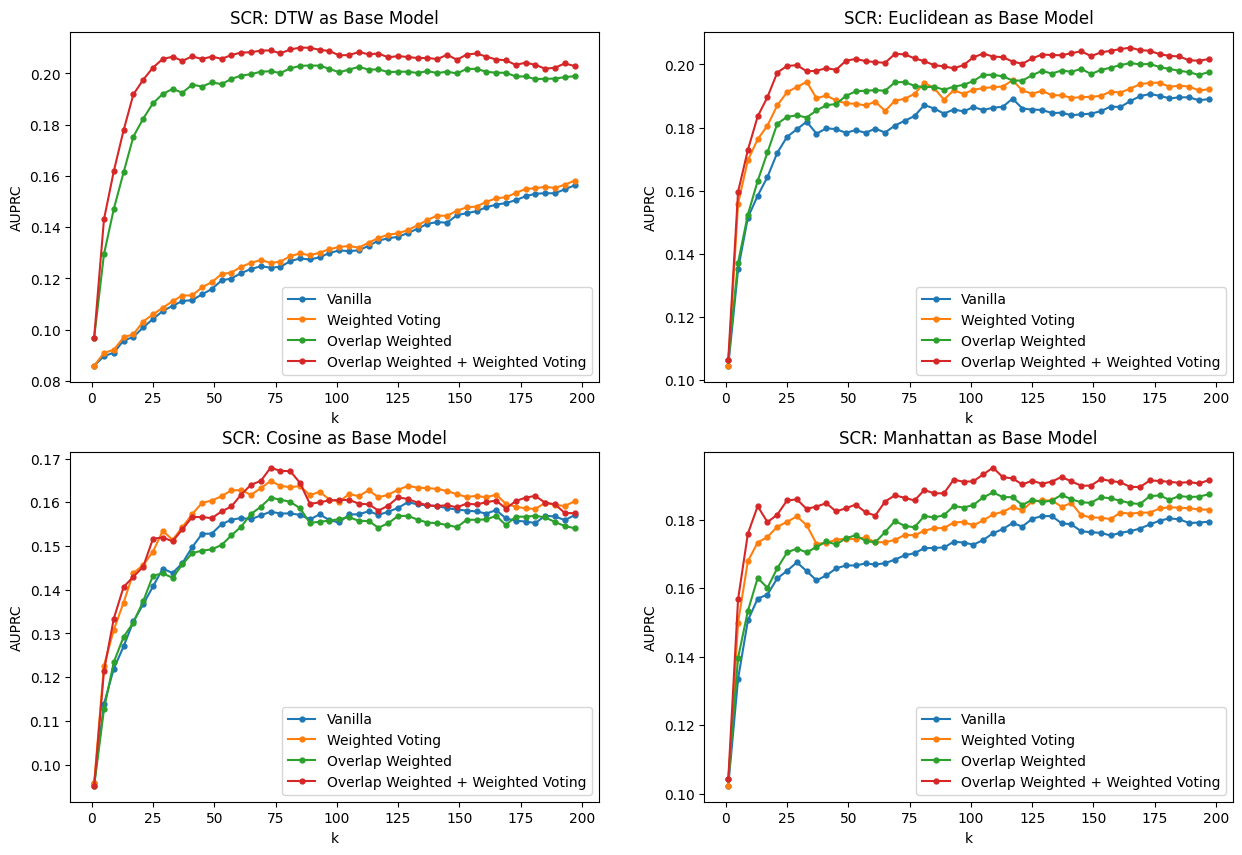

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0,0], 
                   k_sizes,
                   SCR_DTW_control["Vanilla"][metric], 
                   SCR_DTW_control["WV"][metric], 
                   SCR_DTW_control["OW"][metric], 
                   SCR_DTW_control["OW+WV"][metric], 
                   "SCR: DTW as Base Model")

plot_AUPRC_along_k(axs[0,1], 
                   k_sizes,
                   SCR_Euc_control["Vanilla"][metric], 
                   SCR_Euc_control["WV"][metric], 
                   SCR_Euc_control["OW"][metric], 
                   SCR_Euc_control["OW+WV"][metric], 
                   "SCR: Euclidean as Base Model")
plot_AUPRC_along_k(axs[1,0], 
                   k_sizes,
                   SCR_Cos_control["Vanilla"][metric], 
                   SCR_Cos_control["WV"][metric], 
                   SCR_Cos_control["OW"][metric], 
                   SCR_Cos_control["OW+WV"][metric], 
                   "SCR: Cosine as Base Model")
plot_AUPRC_along_k(axs[1,1], 
                   k_sizes,
                   SCR_Manh_control["Vanilla"][metric], 
                   SCR_Manh_control["WV"][metric], 
                   SCR_Manh_control["OW"][metric], 
                   SCR_Manh_control["OW+WV"][metric], 
                   "SCR: Manhattan as Base Model")

plt.show()

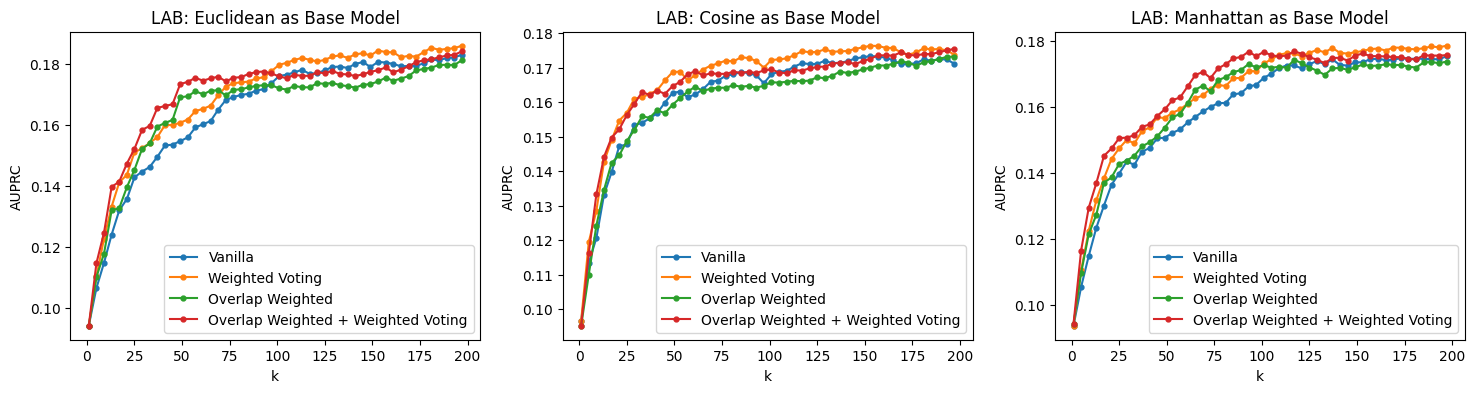

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_AUPRC_along_k(axs[0], 
                   k_sizes,
                   LAB_Euc_control["Vanilla"][metric], 
                   LAB_Euc_control["WV"][metric], 
                   LAB_Euc_control["OW"][metric], 
                   LAB_Euc_control["OW+WV"][metric], 
                   "LAB: Euclidean as Base Model")
plot_AUPRC_along_k(axs[1], 
                   k_sizes,
                   LAB_Cos_control["Vanilla"][metric], 
                   LAB_Cos_control["WV"][metric], 
                   LAB_Cos_control["OW"][metric], 
                   LAB_Cos_control["OW+WV"][metric], 
                   "LAB: Cosine as Base Model")
plot_AUPRC_along_k(axs[2], 
                   k_sizes,
                   LAB_Manh_control["Vanilla"][metric], 
                   LAB_Manh_control["WV"][metric], 
                   LAB_Manh_control["OW"][metric], 
                   LAB_Manh_control["OW+WV"][metric], 
                   "LAB: Manhattan as Base Model")

plt.show()

# Prove Searched Distance Measures are Better

In [101]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import plot_control_vs_exp_performance

In [102]:
SCR_control_measure_names = ["DTW", "Euc", "Manh", "Cos"]

SCR_no_vv_eva_controls = [SCR_DTW_control["Vanilla"]["AUPRC"], SCR_Euc_control["Vanilla"]["AUPRC"],
                         SCR_Manh_control["Vanilla"]["AUPRC"], SCR_Cos_control["Vanilla"]["AUPRC"]]
SCR_no_wv_eva_controls = [SCR_DTW_control["WV"]["AUPRC"], SCR_Euc_control["WV"]["AUPRC"],
                         SCR_Manh_control["WV"]["AUPRC"], SCR_Cos_control["WV"]["AUPRC"]]
SCR_ow_vv_eva_controls = [SCR_DTW_control["OW"]["AUPRC"], SCR_Euc_control["OW"]["AUPRC"],
                         SCR_Manh_control["OW"]["AUPRC"], SCR_Cos_control["OW"]["AUPRC"]]
SCR_ow_wv_eva_controls = [SCR_DTW_control["OW+WV"]["AUPRC"], SCR_Euc_control["OW+WV"]["AUPRC"],
                         SCR_Manh_control["OW+WV"]["AUPRC"], SCR_Cos_control["OW+WV"]["AUPRC"]]

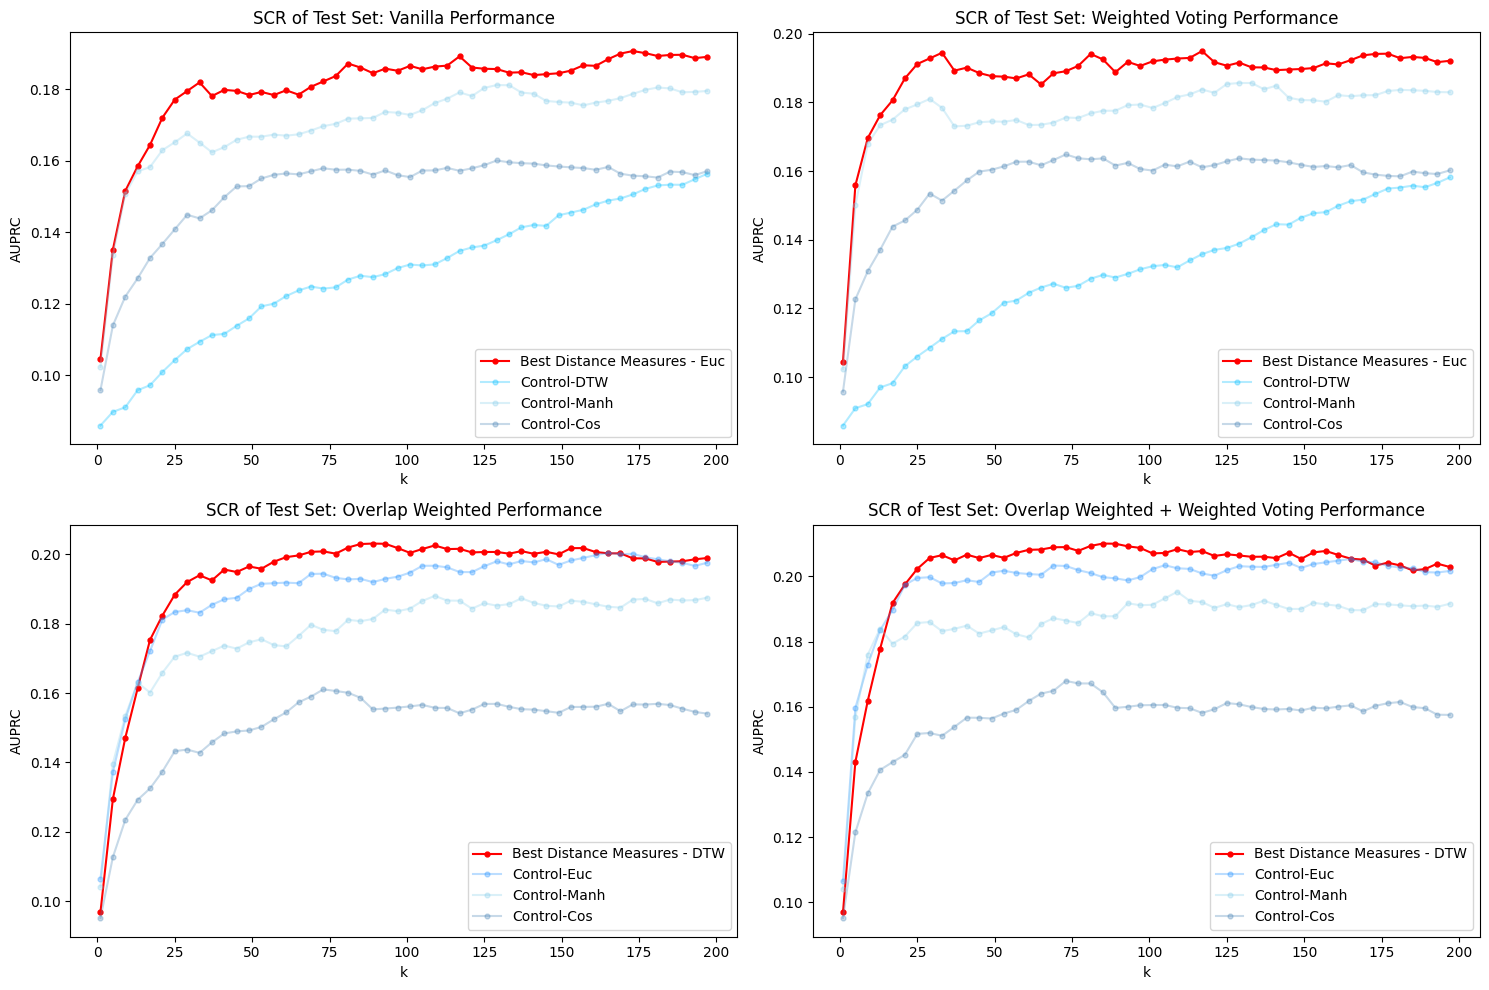

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_control_vs_exp_performance(axs[0, 0], k_sizes, SCR_no_vv_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR Vanilla"], 'SCR of Test Set: Vanilla Performance')
plot_control_vs_exp_performance(axs[0, 1], k_sizes, SCR_no_wv_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR Vanilla"],'SCR of Test Set: Weighted Voting Performance')
plot_control_vs_exp_performance(axs[1, 0], k_sizes, SCR_ow_vv_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR OW"],'SCR of Test Set: Overlap Weighted Performance')
plot_control_vs_exp_performance(axs[1, 1], k_sizes, SCR_ow_wv_eva_controls, SCR_control_measure_names, 
                                best_method_each_condition["SCR OW"],'SCR of Test Set: Overlap Weighted + Weighted Voting Performance')

plt.tight_layout()
plt.show()

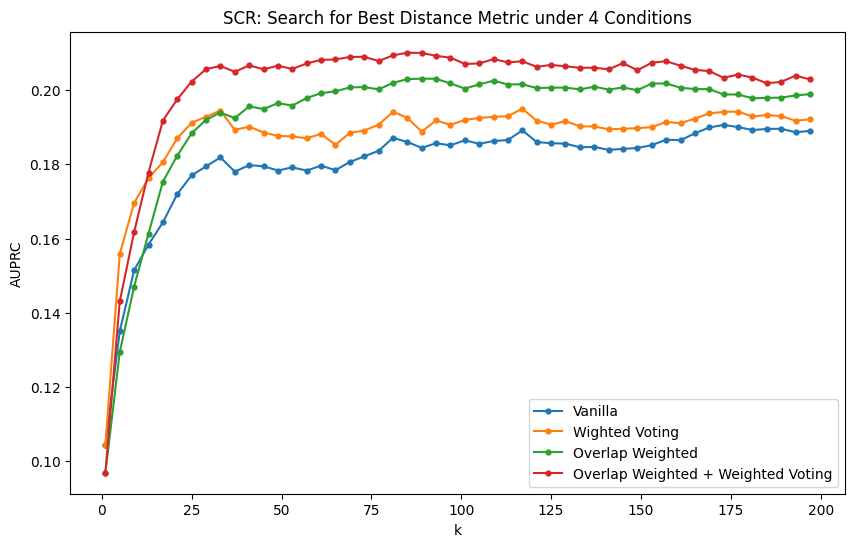

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(k_sizes, SCR_no_vv_eva["AUPRC"], label = "Vanilla", marker='.', markersize=7)
plt.plot(k_sizes, SCR_no_wv_eva["AUPRC"], label = "Wighted Voting", marker='.', markersize=7)
plt.plot(k_sizes, SCR_ow_vv_eva["AUPRC"], label = "Overlap Weighted", marker='.', markersize=7)
plt.plot(k_sizes, SCR_ow_wv_eva["AUPRC"], label = "Overlap Weighted + Weighted Voting", marker='.', markersize=7)
plt.title("SCR: Search for Best Distance Metric under 4 Conditions")
plt.ylabel('AUPRC')
plt.xlabel('k')
plt.legend()
plt.show()

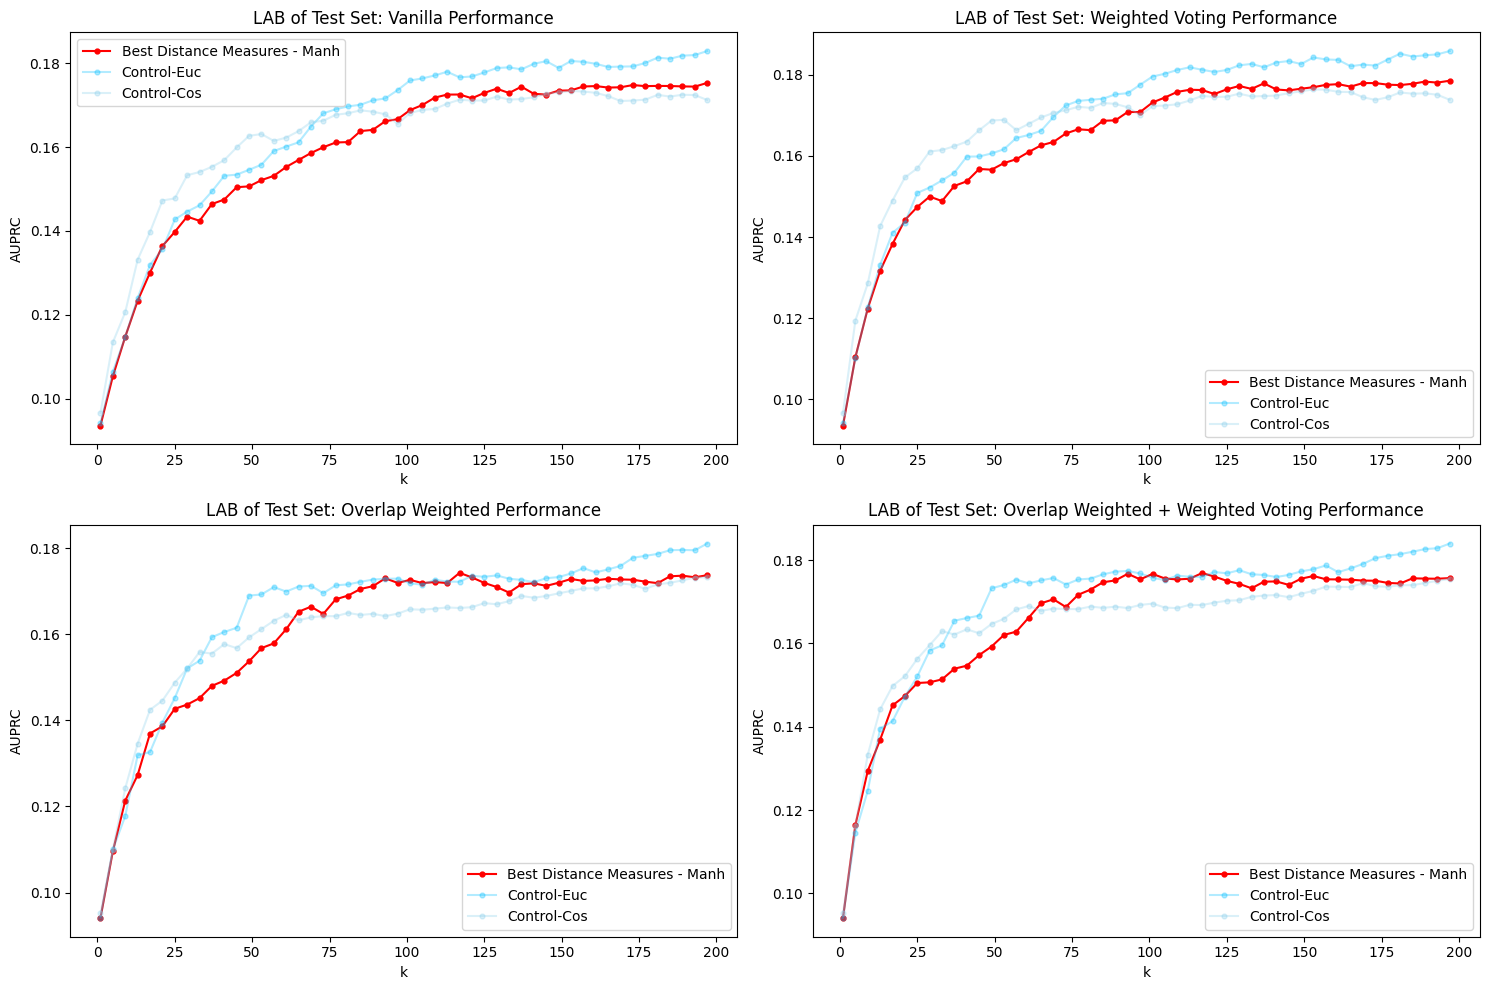

In [105]:
LAB_control_measure_names = ["Euc", "Manh", "Cos"]
LAB_no_vv_eva_controls = [LAB_Euc_control["Vanilla"]["AUPRC"], LAB_Manh_control["Vanilla"]["AUPRC"], LAB_Cos_control["Vanilla"]["AUPRC"]]
LAB_no_wv_eva_controls = [LAB_Euc_control["WV"]["AUPRC"], LAB_Manh_control["WV"]["AUPRC"], LAB_Cos_control["WV"]["AUPRC"]]
LAB_ow_vv_eva_controls = [LAB_Euc_control["OW"]["AUPRC"], LAB_Manh_control["OW"]["AUPRC"], LAB_Cos_control["OW"]["AUPRC"]]
LAB_ow_wv_eva_controls = [LAB_Euc_control["OW+WV"]["AUPRC"], LAB_Manh_control["OW+WV"]["AUPRC"], LAB_Cos_control["OW+WV"]["AUPRC"]]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_control_vs_exp_performance(axs[0, 0], k_sizes, LAB_no_vv_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB Vanilla"], 'LAB of Test Set: Vanilla Performance')
plot_control_vs_exp_performance(axs[0, 1], k_sizes, LAB_no_wv_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB Vanilla"], 'LAB of Test Set: Weighted Voting Performance')
plot_control_vs_exp_performance(axs[1, 0], k_sizes, LAB_ow_vv_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB OW"], 'LAB of Test Set: Overlap Weighted Performance')
plot_control_vs_exp_performance(axs[1, 1], k_sizes, LAB_ow_wv_eva_controls, LAB_control_measure_names, 
                                best_method_each_condition["LAB OW"], 'LAB of Test Set: Overlap Weighted + Weighted Voting Performance')

plt.tight_layout()
plt.show()

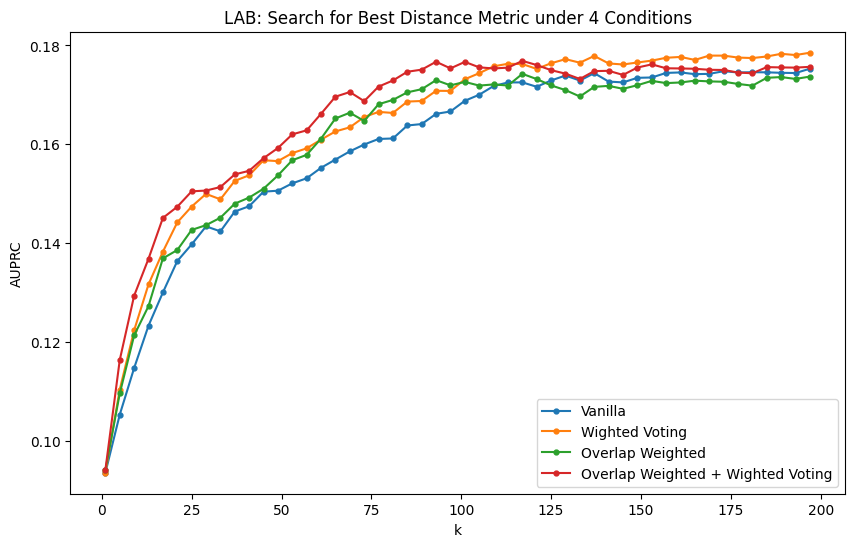

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(k_sizes, LAB_no_vv_eva["AUPRC"], label = "Vanilla", marker='.', markersize=7)
plt.plot(k_sizes, LAB_no_wv_eva["AUPRC"], label = "Wighted Voting", marker='.', markersize=7)
plt.plot(k_sizes, LAB_ow_vv_eva["AUPRC"], label = "Overlap Weighted", marker='.', markersize=7)
plt.plot(k_sizes, LAB_ow_wv_eva["AUPRC"], label = "Overlap Weighted + Wighted Voting", marker='.', markersize=7)
plt.title("LAB: Search for Best Distance Metric under 4 Conditions")
plt.ylabel('AUPRC')
plt.xlabel('k')
plt.legend()
plt.show()

# Prove that Searched Weight Combination Better

In [107]:
all_simi_mtx_collection = dict()

all_simi_mtx_collection["SCR"] = dict()
all_simi_mtx_collection["LAB"] = dict()

all_simi_mtx_collection["SCR"]["DTW"] = SCR_DTW_simi
all_simi_mtx_collection["SCR"]["Euc"] = SCR_Euc_simi
all_simi_mtx_collection["SCR"]["Cos"] = SCR_Cos_simi
all_simi_mtx_collection["SCR"]["Manh"] = SCR_Manh_simi


all_simi_mtx_collection["LAB"]["Euc"] = LAB_Euc_simi
all_simi_mtx_collection["LAB"]["Manh"] = LAB_Manh_simi
all_simi_mtx_collection["LAB"]["Cos"] = LAB_Cos_simi

all_simi_w_mtx_collection = dict()

all_simi_w_mtx_collection["SCR"] = dict()
all_simi_w_mtx_collection["LAB"] = dict()

all_simi_w_mtx_collection["SCR"]["DTW"] = SCR_DTW_simi_w
all_simi_w_mtx_collection["SCR"]["Euc"] = SCR_Euc_simi_w
all_simi_w_mtx_collection["SCR"]["Cos"] = SCR_Cos_simi_w
all_simi_w_mtx_collection["SCR"]["Manh"] = SCR_Manh_simi_w

all_simi_w_mtx_collection["LAB"]["Euc"] = LAB_Euc_simi_w
all_simi_w_mtx_collection["LAB"]["Manh"] = LAB_Manh_simi_w
all_simi_w_mtx_collection["LAB"]["Cos"] = LAB_Cos_simi_w

In [108]:
# we do not need to pass all the mtx, just need the best method one
best_measure_simi_mtx = dict()
best_measure_simi_w_mtx = dict()

best_measure_simi_mtx["SCR"] = all_simi_mtx_collection["SCR"][best_method_each_condition["SCR Vanilla"]]
best_measure_simi_mtx["LAB"] = all_simi_mtx_collection["LAB"][best_method_each_condition["LAB Vanilla"]]

best_measure_simi_w_mtx["SCR"] = all_simi_w_mtx_collection["SCR"][best_method_each_condition["SCR OW"]]
best_measure_simi_w_mtx["LAB"] = all_simi_w_mtx_collection["LAB"][best_method_each_condition["LAB OW"]]

In [109]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import test_final_personalized_model, \
get_weight_control_performance, plot_weight_combo_control_performance

In [110]:
y = np.array(dataset["AKI_LABEL"])

In [111]:
final_performance_no_vv = test_final_personalized_model(k_sizes, False, False, 
                                                       grid_search_table,
                                                       train_idx, test_idx, y, y_test, 
                                                       best_measure_simi_mtx)

100%|██████████| 50/50 [41:16<00:00, 49.53s/it]


In [112]:
with open('./Results_dict/External/final_performance_no_vv.json', 'w') as file:
    json.dump(final_performance_no_vv, file)

In [113]:
final_performance_no_wv = test_final_personalized_model(k_sizes, False, True, 
                                                       grid_search_table,
                                                       train_idx, test_idx, y, y_test, 
                                                       best_measure_simi_mtx)

100%|██████████| 50/50 [42:26<00:00, 50.93s/it]


In [114]:
with open('./Results_dict/External/final_performance_no_wv.json', 'w') as file:
    json.dump(final_performance_no_wv, file)

In [115]:
final_performance_ow_vv = test_final_personalized_model(k_sizes, True, False, 
                                                        grid_search_table,
                                                        train_idx, test_idx, y, y_test, 
                                                        best_measure_simi_w_mtx)

100%|██████████| 50/50 [38:59<00:00, 46.80s/it]


In [116]:
with open('./Results_dict/External/final_performance_ow_vv.json', 'w') as file:
    json.dump(final_performance_ow_vv, file)

In [117]:
final_performance_ow_wv = test_final_personalized_model(k_sizes, True, True, 
                                                       grid_search_table,
                                                       train_idx, test_idx, y, y_test, 
                                                       best_measure_simi_w_mtx)

100%|██████████| 50/50 [42:43<00:00, 51.28s/it]


In [118]:
with open('./Results_dict/External/final_performance_ow_wv.json', 'w') as file:
    json.dump(final_performance_ow_wv, file)

In [119]:
%store -r weight_combos

In [120]:
weight_control_performance_no_vv = get_weight_control_performance(k_sizes, False, False, 
                                  weight_combos, train_idx, test_idx, y, y_test, best_measure_simi_mtx)

100%|██████████| 9/9 [08:29<00:00, 56.65s/it]


In [121]:
with open('./Results_dict/External/weight_control_performance_no_vv.json', 'w') as file:
    json.dump(weight_control_performance_no_vv, file)

In [122]:
weight_control_performance_no_wv = get_weight_control_performance(k_sizes, False, True, 
                                                       weight_combos, train_idx, test_idx, y, y_test, best_measure_simi_mtx)

100%|██████████| 9/9 [08:06<00:00, 54.11s/it]


In [123]:
with open('./Results_dict/External/weight_control_performance_no_wv.json', 'w') as file:
    json.dump(weight_control_performance_no_wv, file)

In [124]:
weight_control_performance_ow_vv = get_weight_control_performance(k_sizes, True, False, 
                                                       weight_combos, train_idx, test_idx, y, y_test, best_measure_simi_w_mtx)

100%|██████████| 9/9 [08:22<00:00, 55.79s/it]


In [125]:
with open('./Results_dict/External/weight_control_performance_ow_vv.json', 'w') as file:
    json.dump(weight_control_performance_ow_vv, file)

In [126]:
weight_control_performance_ow_wv = get_weight_control_performance(k_sizes, True, True, 
                                                       weight_combos, train_idx, test_idx, y, y_test, best_measure_simi_w_mtx)

100%|██████████| 9/9 [09:00<00:00, 60.09s/it]


In [127]:
with open('./Results_dict/External/weight_control_performance_ow_wv.json', 'w') as file:
    json.dump(weight_control_performance_ow_wv, file)

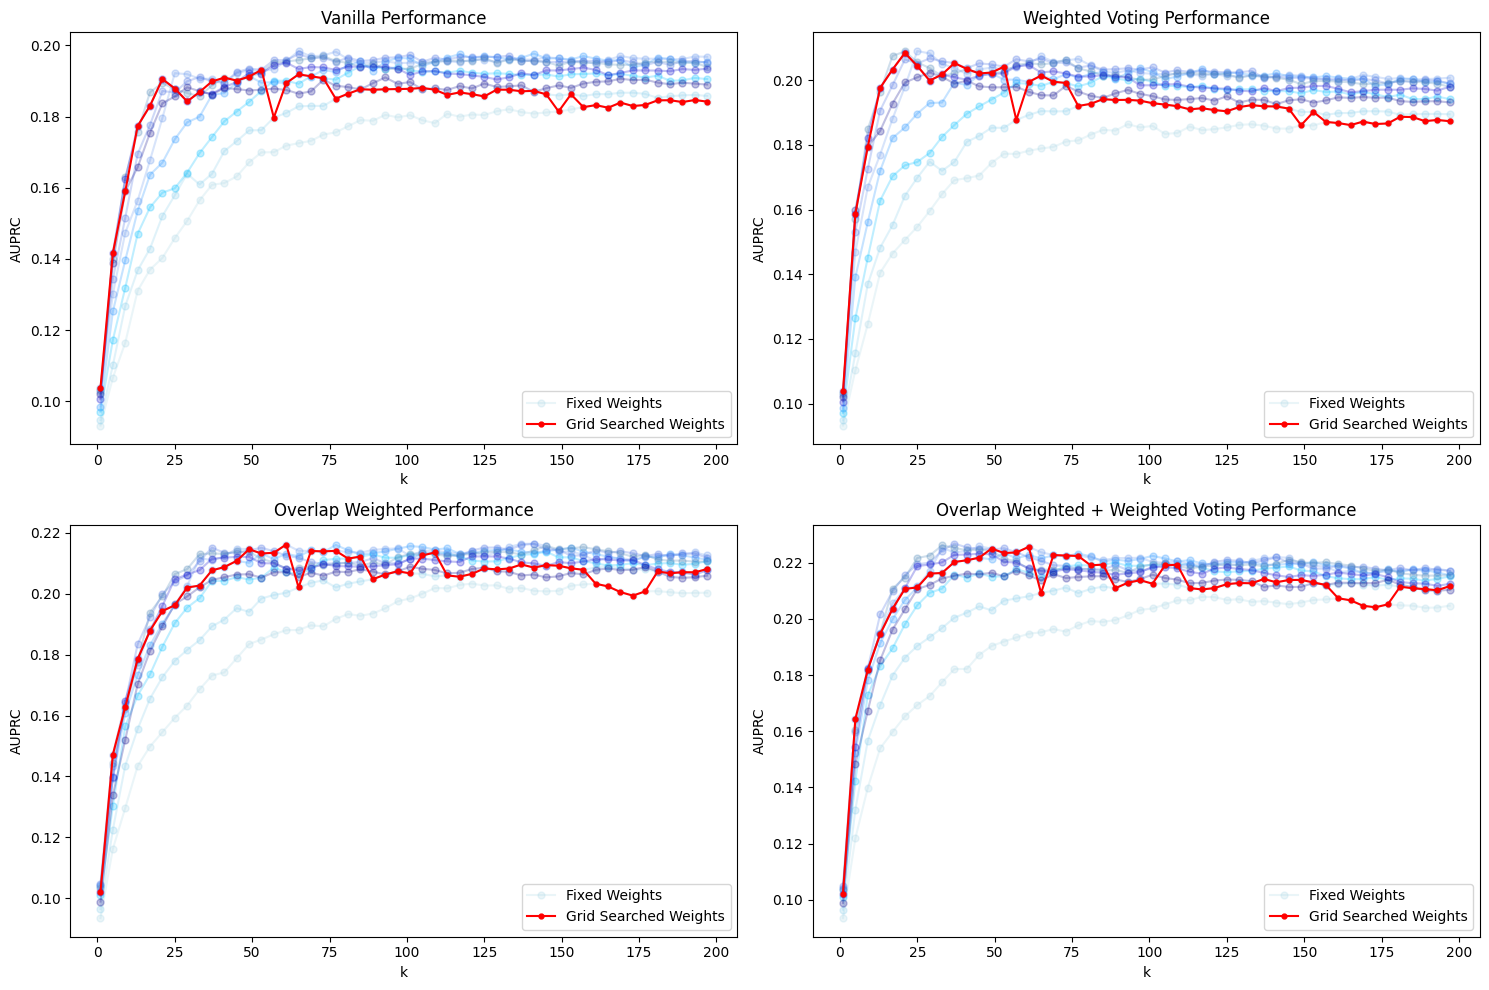

In [128]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid of subplots, adjust the figure size as needed

plot_weight_combo_control_performance(axs[0, 0], k_sizes, weight_control_performance_no_vv, 
                                      final_performance_no_vv, "Vanilla Performance")
plot_weight_combo_control_performance(axs[0, 1], k_sizes, weight_control_performance_no_wv, 
                                      final_performance_no_wv, "Weighted Voting Performance")
plot_weight_combo_control_performance(axs[1, 0], k_sizes, weight_control_performance_ow_vv, 
                                      final_performance_ow_vv, "Overlap Weighted Performance")
plot_weight_combo_control_performance(axs[1, 1], k_sizes, weight_control_performance_ow_wv, 
                                      final_performance_ow_wv, "Overlap Weighted + Weighted Voting Performance")

plt.tight_layout()
plt.show()

# Final Performance

In [129]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score,f1_score

In [130]:
SCR_train_ip = SCR_ip.loc[list(train_idx), :]
SCR_test_ip = SCR_ip.loc[list(test_idx), :]

In [131]:
X_train_glob = pd.concat([SCR_train_ip, LAB_train], axis = 1)
X_test_glob = pd.concat([SCR_test_ip, LAB_test], axis = 1)

In [132]:
y_train = list(data_train["AKI_LABEL"])

In [133]:
glob_KNN_Euc_performance = dict()
glob_KNN_Euc_performance["AUPRC"] = []
glob_KNN_Euc_performance["AUROC"] = []
glob_KNN_Euc_performance["F1"] = []

for k in tqdm(k_sizes):
    knn = KNeighborsClassifier(n_neighbors=k, p = 2)
    knn.fit(X_train_glob, y_train)
    y_probs = knn.predict_proba(X_test_glob)[:, 1]
    y_preds = knn.predict(X_test_glob)
    
    AUPRC_glob = average_precision_score(y_test, y_probs)
    AUROC_glob = roc_auc_score(y_test, y_probs)
    f1_glob = f1_score(y_test, y_preds)
    
    glob_KNN_Euc_performance["AUPRC"].append(AUPRC_glob)
    glob_KNN_Euc_performance["AUROC"].append(AUROC_glob)
    glob_KNN_Euc_performance["F1"].append(f1_glob)

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


In [134]:
with open('./Results_dict/External/glob_KNN_Euc_performance.json', 'w') as file:
    json.dump(glob_KNN_Euc_performance, file)

In [135]:
from v2_C_Grid_Search_and_Testing_with_Imputation_2 import plot_final_performance_metrics

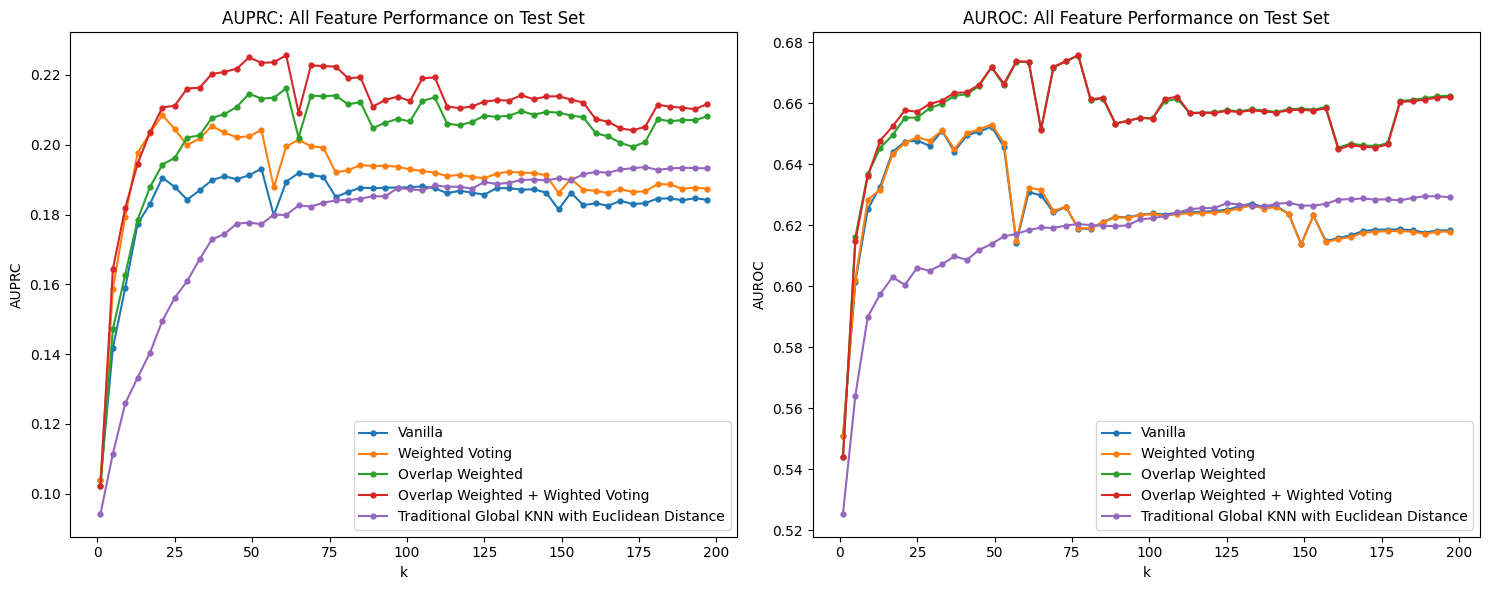

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 2x2 grid of subplots, adjust the figure size as needed

plot_final_performance_metrics(axs[0], k_sizes, "AUPRC", final_performance_no_vv, final_performance_no_wv,
                                  final_performance_ow_vv, final_performance_ow_wv, glob_KNN_Euc_performance)
plot_final_performance_metrics(axs[1], k_sizes, "AUROC", final_performance_no_vv, final_performance_no_wv,
                                  final_performance_ow_vv, final_performance_ow_wv, glob_KNN_Euc_performance)

plt.tight_layout()
plt.show()